# Try to pull something coherent together for a paper

In [1]:
%cd /g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory

/g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory


In [2]:
import xarray as xr

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from src import data, utils, stats, ar_model

import warnings

warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["axes.grid"] = True

In [5]:
DATA_DIR = "../../data/processed/"

## Load some SST data to play with

#### Reanalysis data

In [6]:
def prep_data(ds, hindcast=False):
    """
    Some steps to prepare some data. If processing a hindcast, set
    hindcast=True
    """

    if hindcast:
        coarsen_dim = "lead"
        mean_dim = "init"
    else:
        coarsen_dim = mean_dim = "time"

    # In case time is a dask array
    ds = ds.assign_coords({"time": ds.time.compute()})

    # Annual
    ds = ds.coarsen({coarsen_dim: 12}, boundary="trim", coord_func="max").mean()

    # 5x5 deg grid
    ds = data.interpolate_to_regular_grid(ds.chunk({"lat": -1, "lon": -1}), 5)

    # Anomalies
    ds = ds - ds.mean(mean_dim)

    # Detrend
    ds = utils.detrend(ds, dim=mean_dim)

    return ds.compute()

In [7]:
ds = prep_data(xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True))
reanalysis = ds.assign_coords({"time": ds.time.dt.year})

#### CMIP6 historical data - stack models as ensemble members

In [8]:
historical_models = [
    "CanESM5",
    "CMCC-CM2-SR5",
    "EC-Earth3",
    "HadGEM3-GC31-MM",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MRI-ESM2-0",
    "NorCPM1",
]

historical = []
prev_member = 0
for model in historical_models:
    ds = prep_data(
        xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_historical.zarr", use_cftime=True),
    )
    ds = ds.assign_coords({"time": ds.time.dt.year})

    ds = ds.assign_coords(
        {"member": np.array(range(1, ds.sizes["member"] + 1)) + prev_member}
    )
    ds = ds.assign_coords({"model": ("member", ds.sizes["member"] * [model])})

    historical.append(ds)

    prev_member = ds.member.values[-1]

historical = xr.concat(historical, dim="member")

#### CMIP6 DCPP data - pack into dictionary of models

In [ ]:
dcpp_models = [
    "CanESM5",
    "CESM1-1-CAM5-CMIP5",
    "CMCC-CM2-SR5",
    "EC-Earth3",
    "HadGEM3-GC31-MM",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MRI-ESM2-0",
    "NorCPM1",
]

hindcasts = {}
for model in dcpp_models:
    ds = prep_data(
        xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_dcpp.zarr", use_cftime=True),
        hindcast=True,
    )
    hindcasts[model] = utils.get_hindcast_temporal_mean(ds, mean_lead_ranges=[(0, 8)])

#### Mask the land

In [ ]:
mask = (
    reanalysis["sst"].sum("time", skipna=False).notnull()
    & historical["tos"].sum(["time", "member"], skipna=False).notnull()
)

reanalysis = xr.where(mask, reanalysis, 0)
historical = xr.where(mask, historical, 0)

## Fit an AR model to timeseries at each point

In [ ]:
params_reanalysis = ar_model.fit(
    reanalysis,
    n_lags="select_order",
    kwargs={"maxlag": 10},
)

# params_reanalysis = ar_model.fit(
#     reanalysis,
#     n_lags=7,
# )

In [ ]:
# params_historical = ar_model.fit(
#     historical,
#     n_lags="select_order",
#     kwargs={"maxlag": 10},
# )

params_historical = ar_model.fit(historical, n_lags=5)

In [ ]:
def plot_field(ds, ax, vrange, cmap=None):
    p = ds.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=vrange[0],
        vmax=vrange[1],
        cmap=cmap,
        add_colorbar=False,
    )
    p.axes.set_global()
    p.axes.coastlines()
    return p


fig = plt.figure(figsize=(18, 2.5))
axs = fig.subplots(1, 3, subplot_kw=dict(projection=ccrs.PlateCarree(180)))
vrange = (0, 10)

ax = axs[0]
_ = plot_field(params_reanalysis["model_order"].where(mask), ax, vrange)
ax.set_title("Reanalysis")

ax = axs[1]
_ = plot_field(params_historical["model_order"].mean("member").where(mask), ax, vrange)
ax.set_title("Historical, ensemble mean")

ax = axs[2]
p = plot_field(params_historical["model_order"].std("member").where(mask), ax, vrange)
ax.set_title("Historical, ensemble std")

fig.colorbar(p, ax=axs, label="model order")

In [ ]:
lags = [1, 2, 3, 4, 5]

fig = plt.figure(figsize=(18, 2.5 * len(lags)))
axs = fig.subplots(len(lags), 3, subplot_kw=dict(projection=ccrs.PlateCarree(180)))
vrange = (-1, 1)
cmap = "RdBu_r"

for idx, lag in enumerate(lags):
    _ = plot_field(
        params_reanalysis["sst"].sel(params=f"sst.lag{lag}"), axs[idx, 0], vrange, cmap
    )
    _ = plot_field(
        params_historical["tos"].sel(params=f"tos.lag{lag}").mean("member"),
        axs[idx, 1],
        vrange,
        cmap,
    )
    p = plot_field(
        params_historical["tos"].sel(params=f"tos.lag{lag}").std("member"),
        axs[idx, 2],
        vrange,
        cmap,
    )

    if idx == 0:
        axs[idx, 0].set_title("Reanalysis")
        axs[idx, 1].set_title("Historical, ensemble mean")
        axs[idx, 2].set_title("Historical, ensemble std")
    else:
        for col in range(3):
            axs[idx, col].set_title("")
    fig.colorbar(p, ax=axs[idx, :], label=f"Lag {lag} coefficent")

## Generate synthetic hindcasts from the AR model fit at each point. Let's just focus on the reanalysis params and 8-year means for now.

#### How to check that our synthetic hindcasts "look" somewhat like real hindcasts?
Could we check that the real hindcasts ACFs fall within confidence bounds generated from multiple samples of the simulated hindcasts? We've have to do this separately for each of our real hindcast datasets so that we can generate synthetic hindcasts with the same number of ensemble members and time points.

In [497]:
params_use = params_historical.mean("member", keep_attrs=True)

In [504]:
def are_acfs_consistent(hindcast, simulation):
    """
    Check whether the hindcast ACFs fall within confidence bounds generated
    from multiple samples of the simulated hindcasts
    """
    quantile_bounds = (0.025, 0.975)

    hindcast_acf = stats.acf(hindcast.mean("member"))
    simulation_acf = stats.acf(simulation.mean("member"))

    simulation_acf_lower = simulation_acf.quantile(quantile_bounds[0], dim="sample")
    simulation_acf_upper = simulation_acf.quantile(quantile_bounds[1], dim="sample")

    return (
        (hindcast_acf >= simulation_acf_lower) & (hindcast_acf <= simulation_acf_upper)
    ).all("lag")


consistent_acf = []
for model, hindcast in hindcasts.items():
    simulation = ar_model.generate_samples(
        params_use,
        n_times=hindcast.sizes["time"],
        n_samples=50,
        n_members=hindcast.sizes["member"],
        temporal_means=[8],
    )

    consistent_acf.append(
        are_acfs_consistent(hindcast, simulation).assign_coords({"model": model})
    )

consistent_acf = xr.concat(consistent_acf, dim="model")
consistent_acf = xr.concat(
    [
        consistent_acf,
        consistent_acf.any(dim="model").assign_coords({"model": "any"}),
        consistent_acf.all(dim="model").assign_coords({"model": "all"}),
    ],
    dim="model",
)

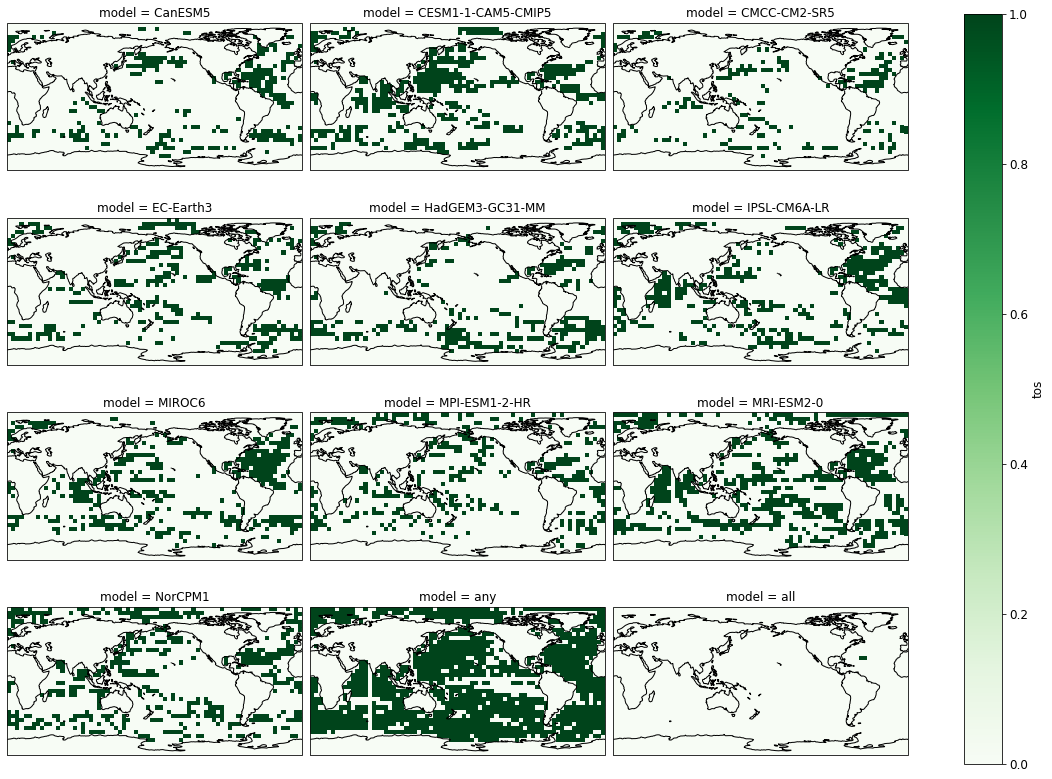

In [505]:
p = consistent_acf["tos"].plot(
    figsize=(16, 11),
    col="model",
    col_wrap=3,
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.PlateCarree(180)},
    cmap="Greens",
)

for ax in p.axes.flat:
    ax.coastlines()

#### How do the ACFs look at specific locations?

Here we focus on the 10-member ensemble average, which means we discard `MPI-ESM1-2-HR`, which has only 5 members 

Text(0, 0.5, 'ACF')

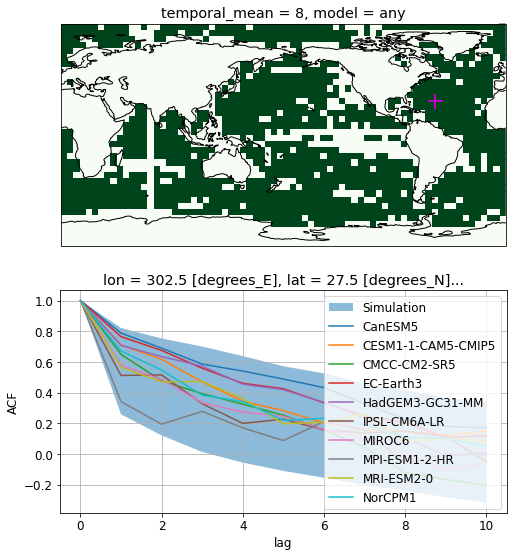

In [528]:
loc = {"lon": 60, "lat": 23}

quantile_bounds = (0.025, 0.975)

fig = plt.figure(figsize=(8, 9))
ax = fig.add_subplot(211, projection=ccrs.PlateCarree(180))

consistent_acf["tos"].sel(model="any").plot(
    ax=ax, cmap="Greens", transform=ccrs.PlateCarree(), add_colorbar=False
)
ax.coastlines()

ax.plot(
    consistent_acf.isel(loc).lon,
    consistent_acf.isel(loc).lat,
    color="m",
    marker="+",
    markersize=15,
    markeredgewidth=2,
    transform=ccrs.PlateCarree(),
)

simulation = ar_model.generate_samples(
    params_use.isel(loc),
    n_times=60,
    n_samples=1000,
    n_members=10,
    temporal_means=[8],
)
simulation_acf = stats.acf(simulation.mean("member"))

ax = fig.add_subplot(212)
ax.fill_between(
    simulation_acf.lag,
    simulation_acf["tos"].quantile(quantile_bounds[0], dim="sample"),
    simulation_acf["tos"].quantile(quantile_bounds[1], dim="sample"),
    alpha=0.5,
    label="Simulation",
)

for model, hindcast in hindcasts.items():
    hindcast_acf = stats.acf(hindcast.isel(loc).mean("member"))
    hindcast_acf["tos"].plot(ax=ax, label=model)

ax.legend()
ax.set_ylabel("ACF")

## What about we just do a rolling mean of the simulations rather than generating forecasts?

In [ ]:
params_use = params_reanalysis

## Things to try

- How do things look if you just do a rolling mean on the simulations?
- Just use AMV as an example

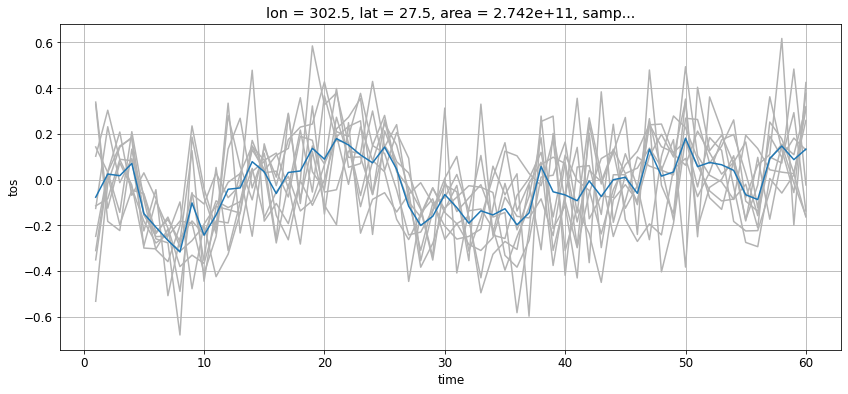

In [526]:
_ = (
    simulation["tos"]
    .isel(sample=0)
    .plot.line(x="time", color=[0.7, 0.7, 0.7], add_legend=False)
)
simulation["tos"].isel(sample=0).mean("member").plot()

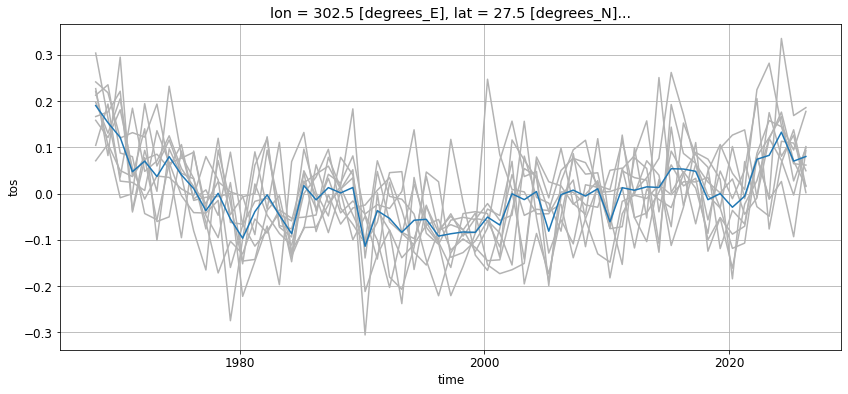

In [527]:
_ = (
    hindcast["tos"]
    .isel(loc)
    .plot.line(x="time", color=[0.7, 0.7, 0.7], add_legend=False)
)
hindcast["tos"].isel(loc).mean("member").plot()